# 403 RNN Regressor

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* matplotlib
* numpy

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

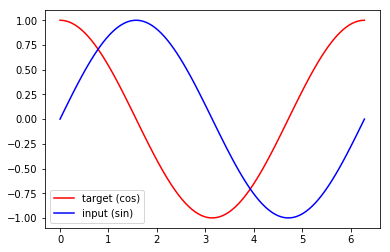

In [4]:
# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32) # float32 for converting torch FloatTensor
x_np = np.sin(steps)    
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        """
        nn.RNN:
        Applies a multi-layer Elman RNN with tanh or ReLU non-linearity to an input sequence.
        
        Inputs: input, h_0
        input of shape (seq_len, batch, input_size): tensor containing the features of the input sequence. The input can also be a packed variable length sequence. See torch.nn.utils.rnn.pack_padded_sequence() or torch.nn.utils.rnn.pack_sequence() for details.
        h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.
        
        Outputs: output, h_n
        output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features (h_k) from the last layer of the RNN, for each k. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence.
        For the unpacked case, the directions can be separated using output.view(seq_len, batch, num_directions, hidden_size), with forward and backward being direction 0 and 1 respectively. Similarly, the directions can be separated in the packed case. 
        h_n (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for k = seq_len.
        Like output, the layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size).
        """
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
    
#         # Method 1:
#         outs = []    # save all predictions
#         for time_step in range(r_out.size(1)):    # calculate output for each time step
#             # r_out[:, time_step, :] : (batch, 1, hidden_size)
#             # self.out(r_out[:, time_step, :]) : (batch, 1, output_size)
#             outs.append(self.out(r_out[:, time_step, :]))
#         # torch.stack(outs, dim=1): (batch, time_step, output_size)  
# #         assert torch.all(torch.eq(torch.stack(outs, dim=1), self.out(r_out))) #True
# #         assert torch.equal(torch.stack(outs, dim=1), self.out(r_out)) # True  
# #         print(torch.stack(outs, dim=1).shape, self.out(r_out).shape)
# #         print(torch.stack(outs, dim=1), self.out(r_out))
#         return torch.stack(outs, dim=1), h_state

#         #Method 2:
#         #instead, for simplicity, you can replace above codes by follows
#         r_out = r_out.view(-1, 32) # can't be used RuntimeError: input and target shapes do not match: input [10 x 1], target [1 x 10 x 1] at ../aten/src/THNN/generic/MSECriterion.c:12
#         outs = self.out(r_out)
#         outs = outs.view(-1, TIME_STEP, 1)
#         return outs, h_state
        
        #Method 3:
        # or even simpler, since nn.Linear can accept inputs of any dimension 
        # and returns outputs with same dimension except for the last
        outs = self.out(r_out)
        return outs, h_state

In [6]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [7]:
a = torch.rand(10,10,32)
r1 = rnn.out(a)

r2 = a
r2 = r2.view(-1, 32)
r2 = rnn.out(r2)
r2 = r2.view(-1, TIME_STEP, 1)

torch.equal(r1, r2)

True

In [8]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

In [9]:
h_state = None      # for initial hidden state

In [10]:
plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

<Figure size 864x360 with 0 Axes>

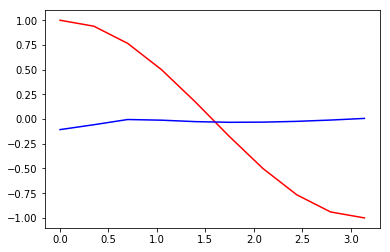

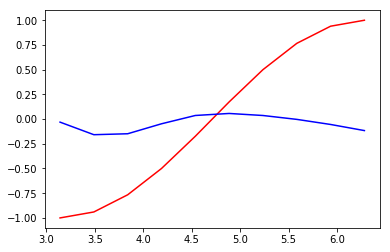

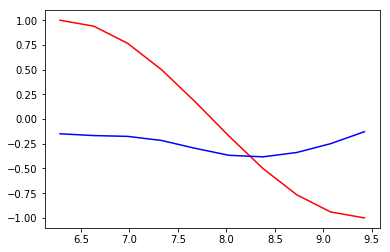

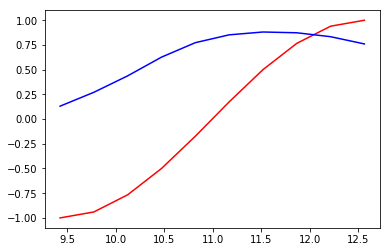

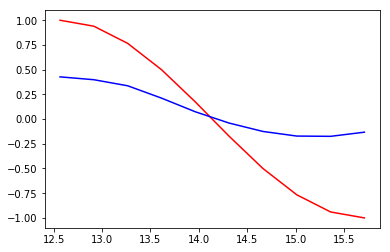

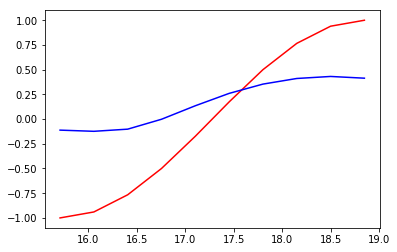

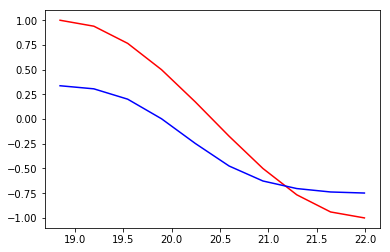

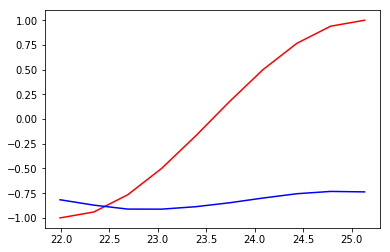

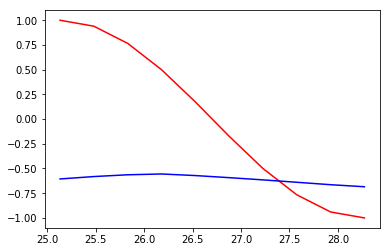

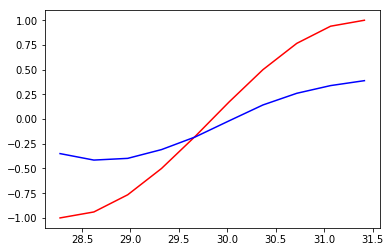

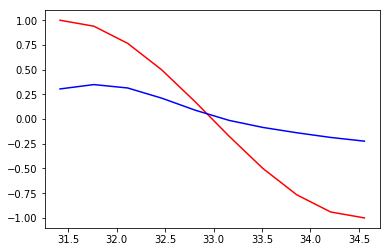

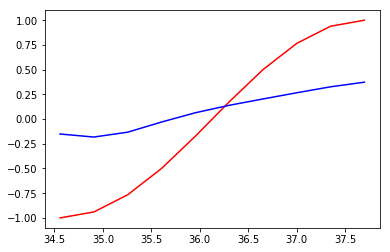

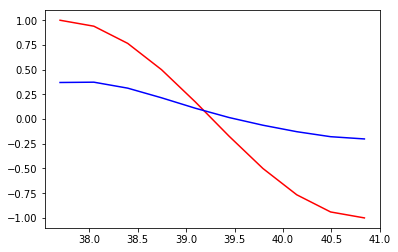

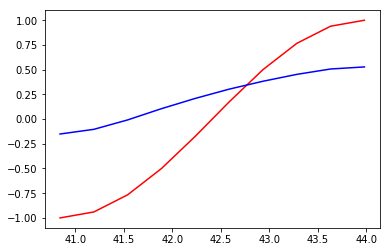

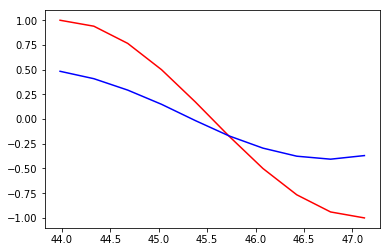

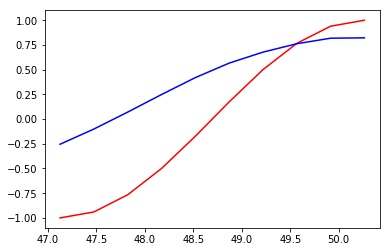

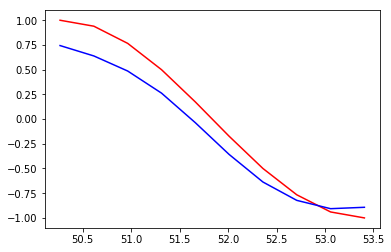

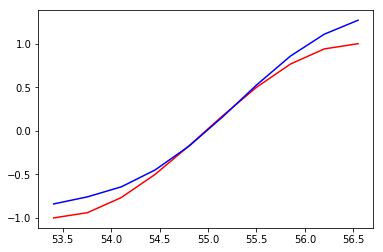

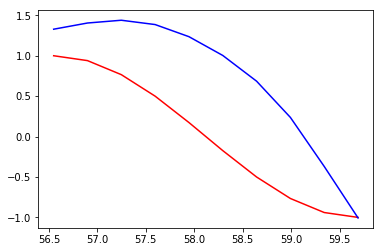

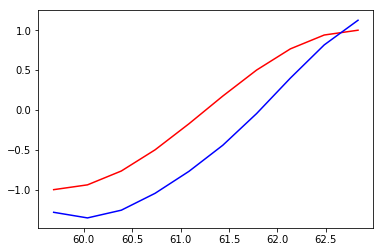

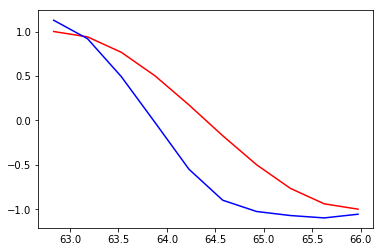

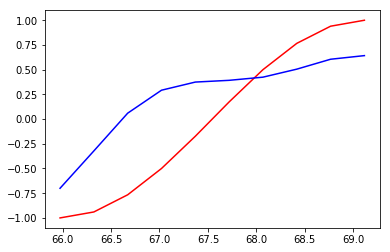

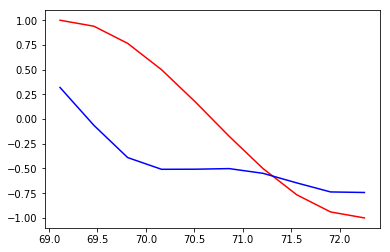

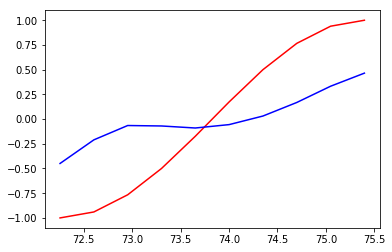

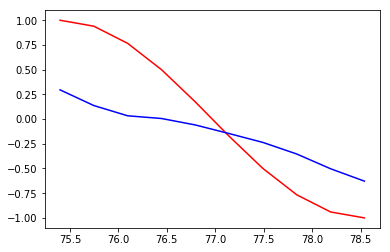

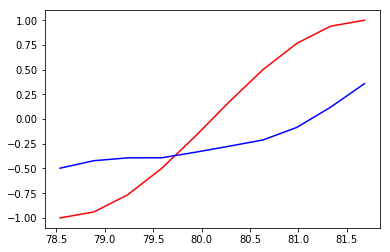

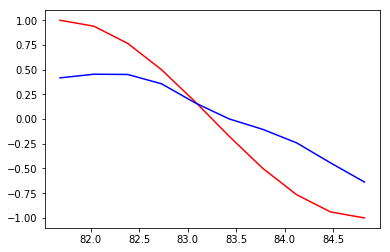

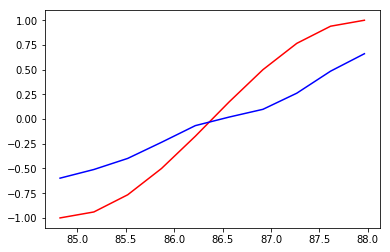

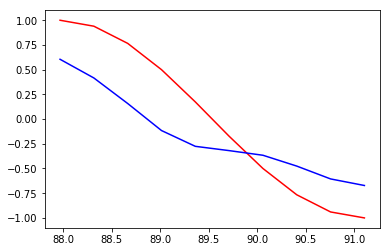

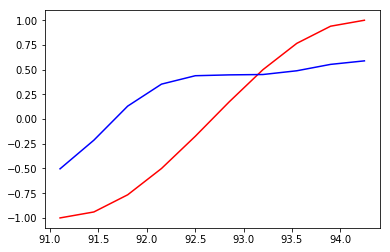

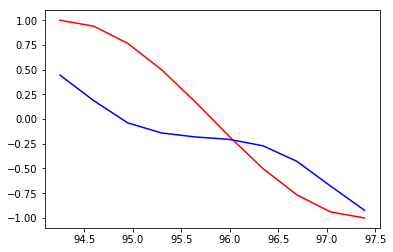

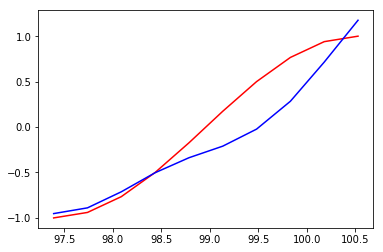

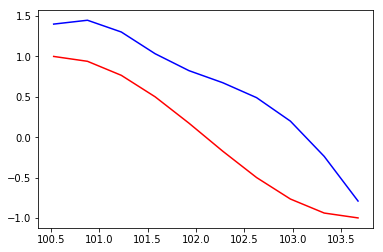

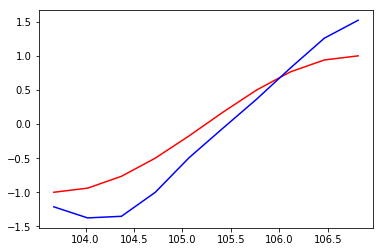

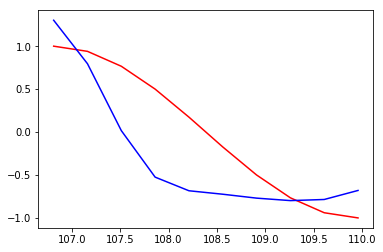

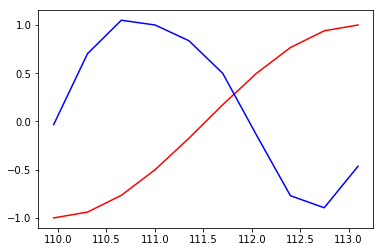

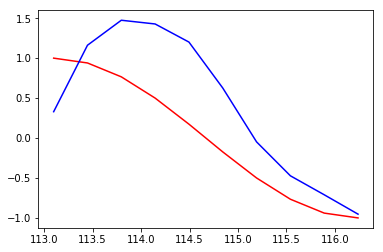

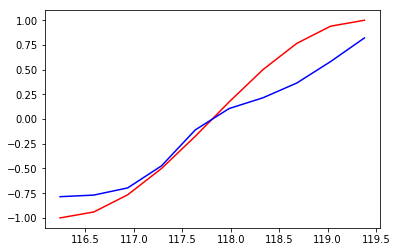

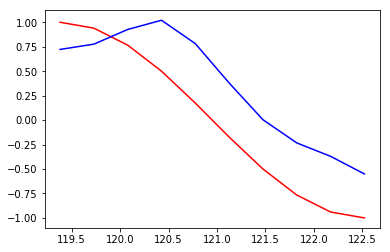

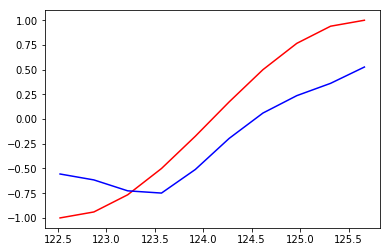

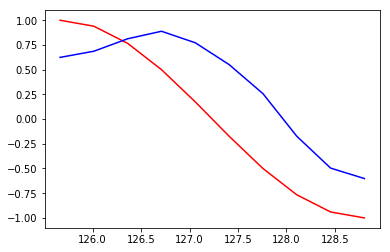

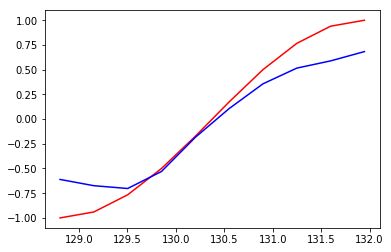

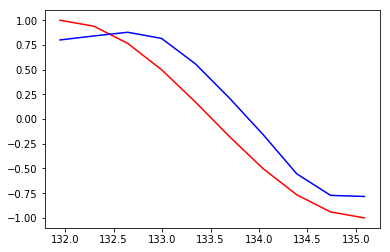

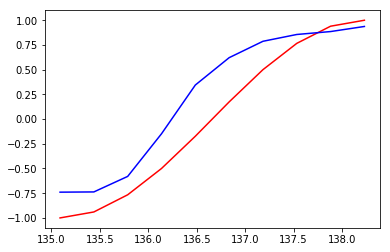

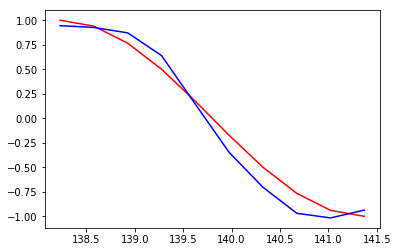

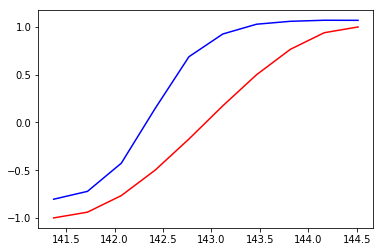

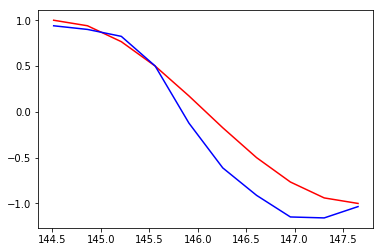

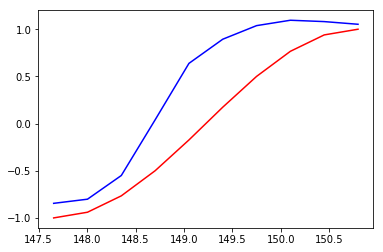

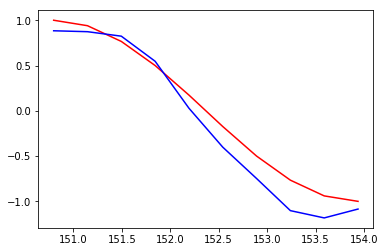

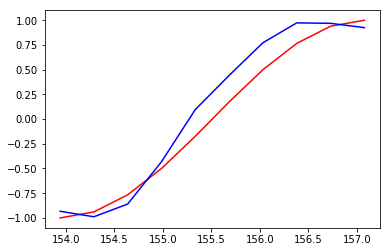

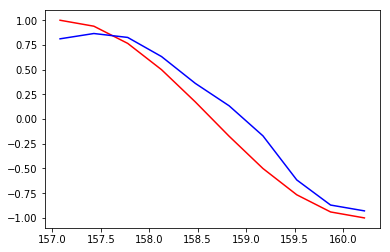

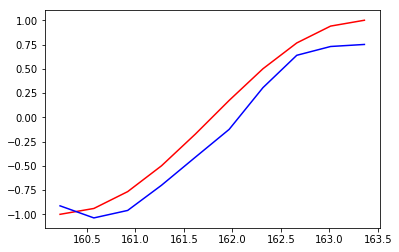

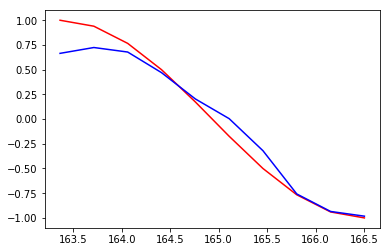

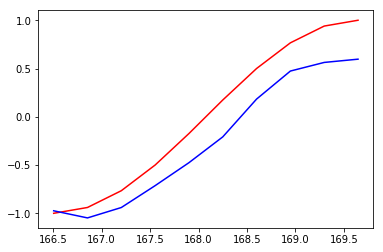

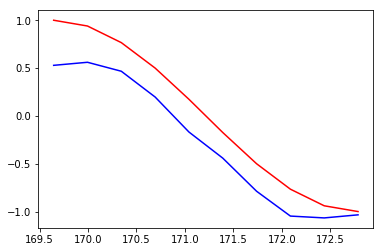

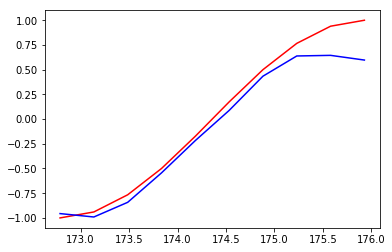

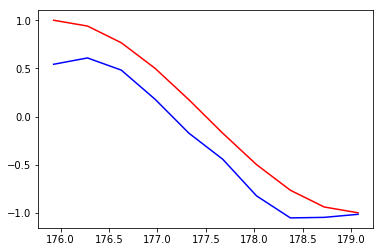

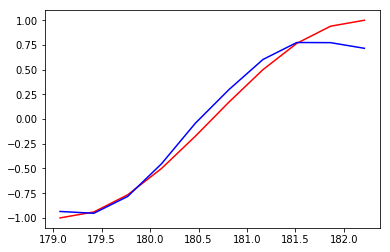

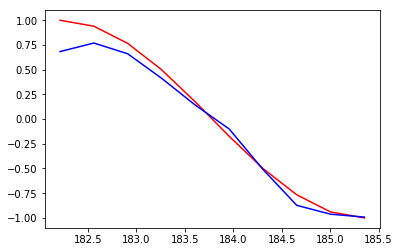

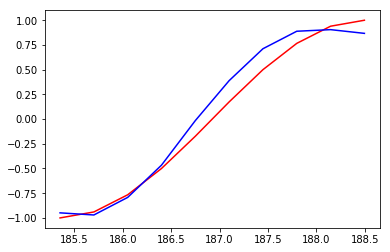

In [11]:
# torch.manual_seed(1)    # reproducible
r1 = []
for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32) # float32 for converting torch FloatTensor
    x_np = np.sin(steps)  
    y_np = np.cos(steps)
    
    """
    https://pytorch.org/blog/pytorch-0_4_0-migration-guide/
    Variable wrapper is no longer needed!
    """
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    # shape (batch, time_step, input_size)
#     y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])   # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]).repeat(2,1,1))    # shape (batch, time_step, input_size)
#     y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]).repeat(2,1,1))
    
    """
    it accept hidden state, because every sample (of shape (1,10,1)) are relevant here
    """
#     h_state = None
    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    """
    The following line solves:
    RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
    """
    h_state = Variable(h_state.data)        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
#     plt.plot(steps, prediction.data[0,...].numpy().flatten(), 'b-') #used when batch_size>=2
    plt.draw(); plt.pause(0.05)
    r1.append(prediction.data.numpy().flatten())


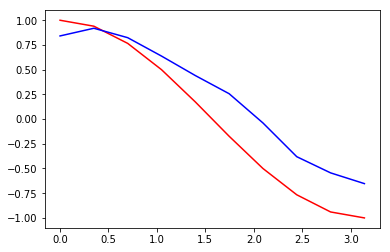

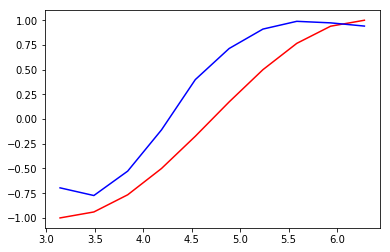

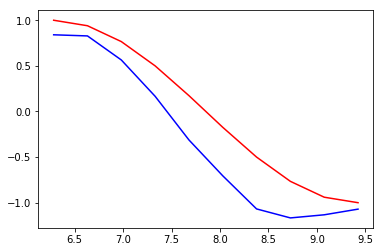

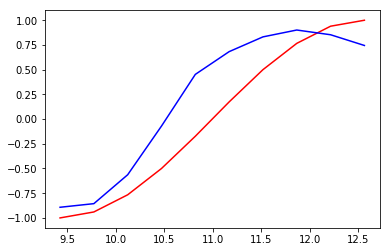

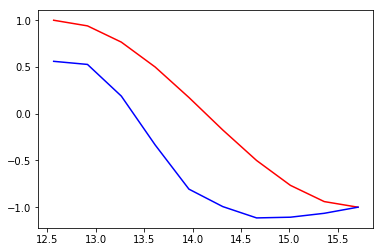

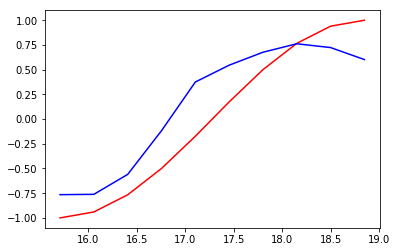

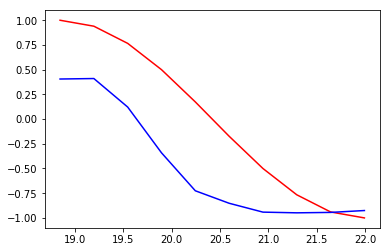

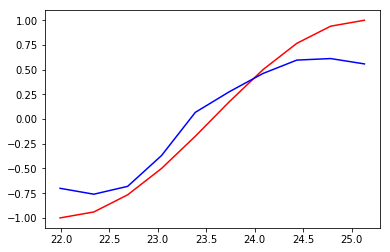

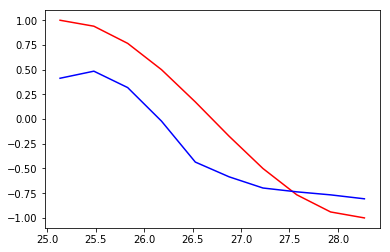

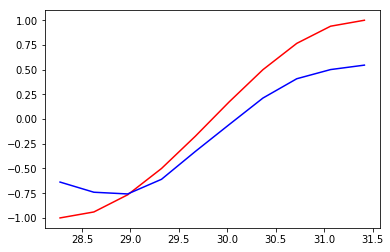

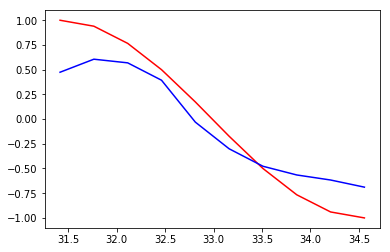

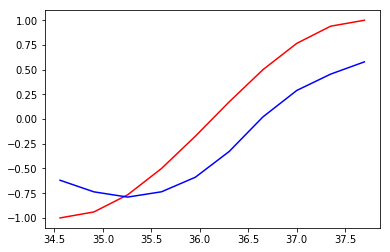

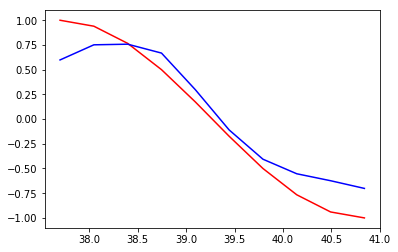

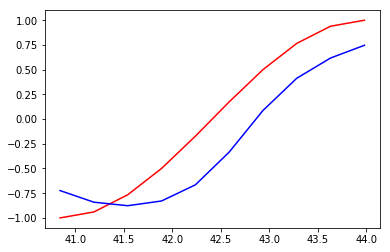

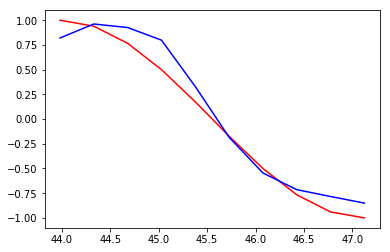

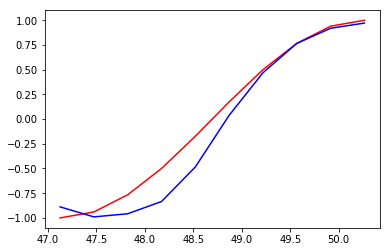

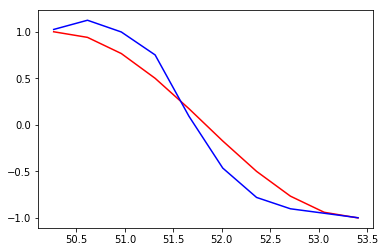

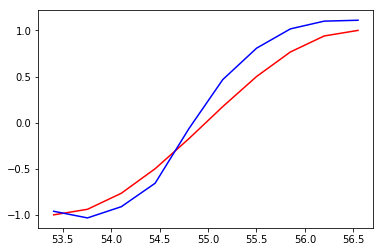

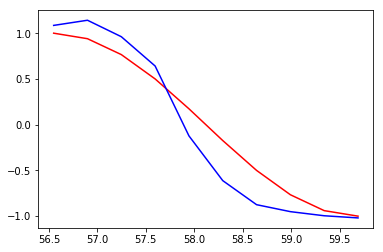

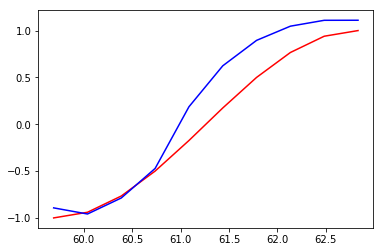

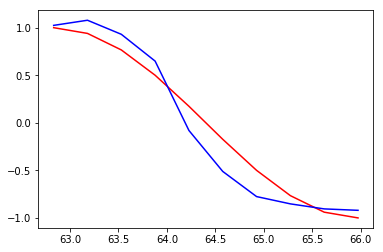

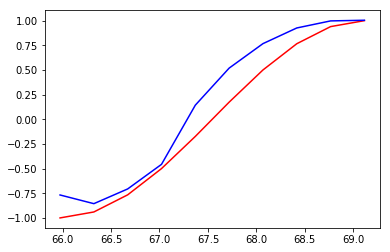

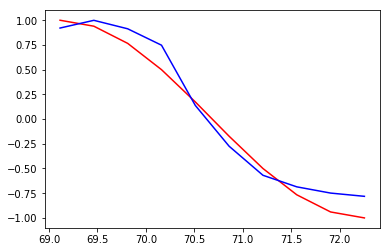

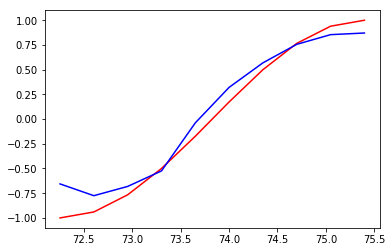

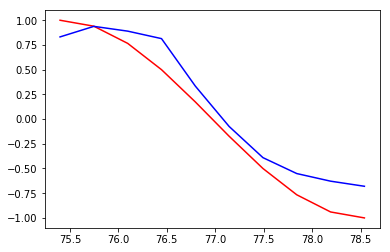

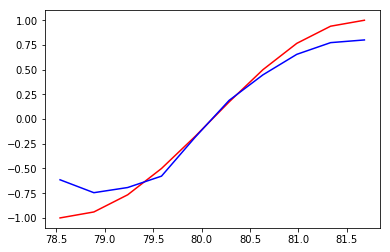

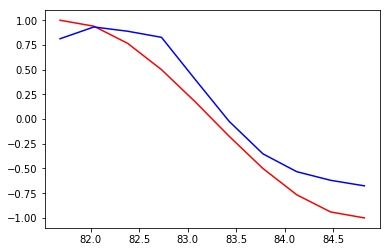

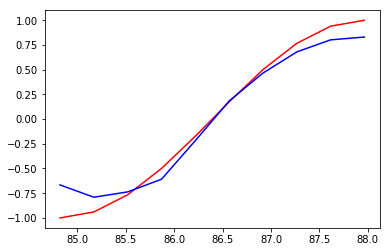

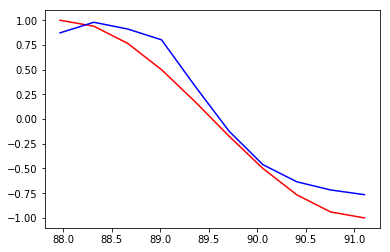

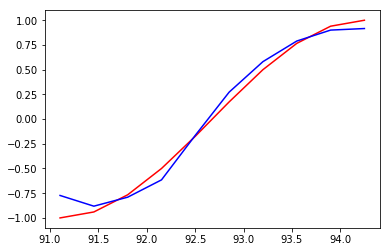

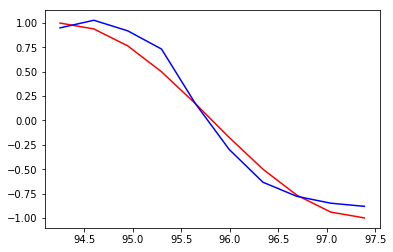

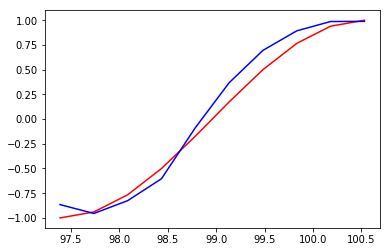

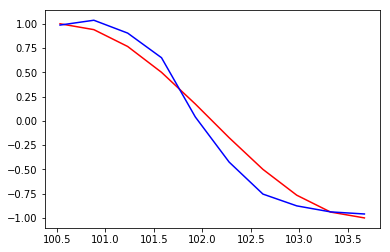

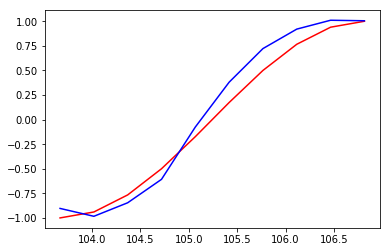

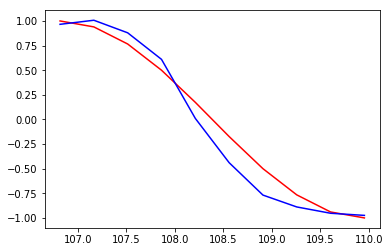

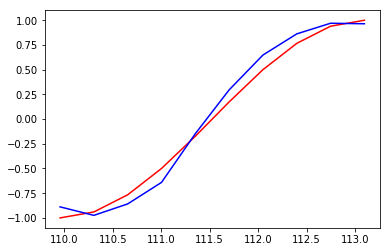

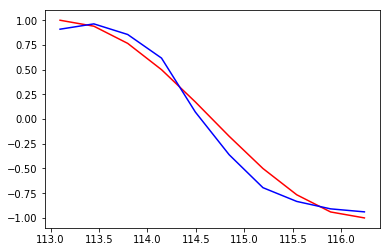

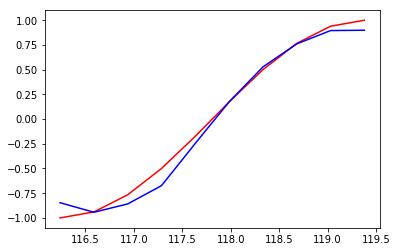

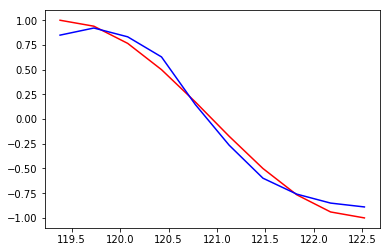

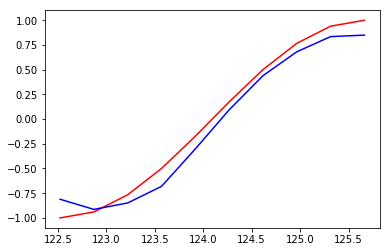

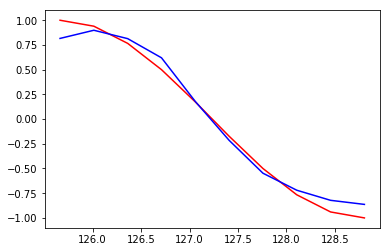

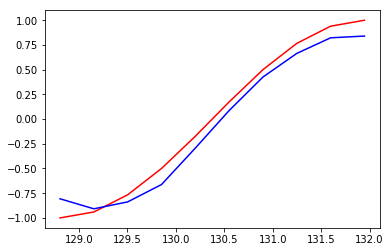

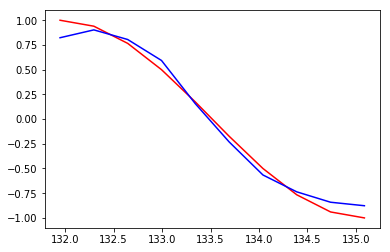

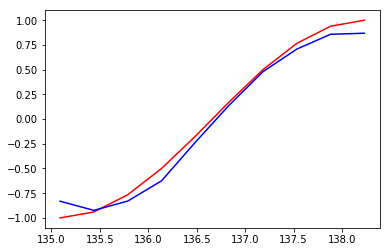

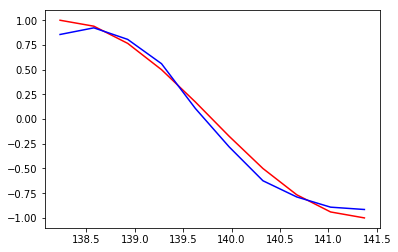

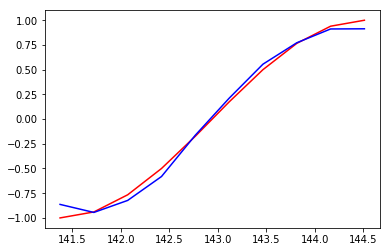

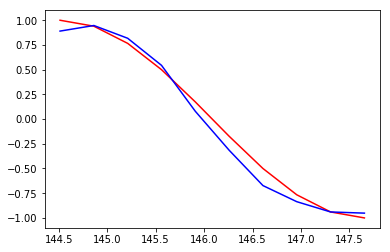

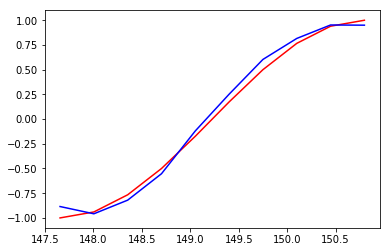

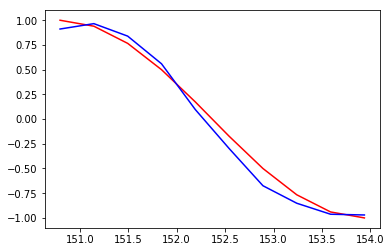

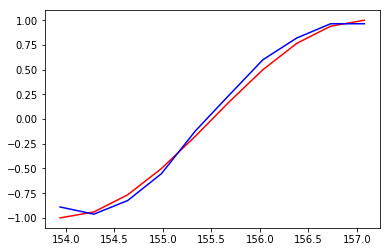

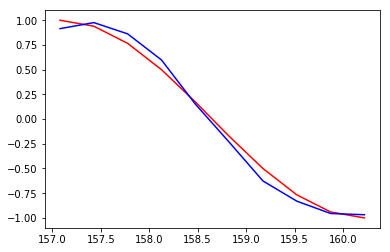

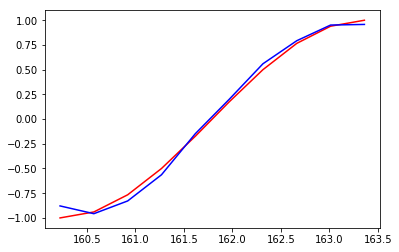

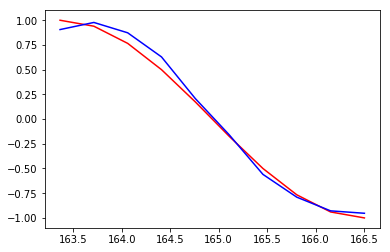

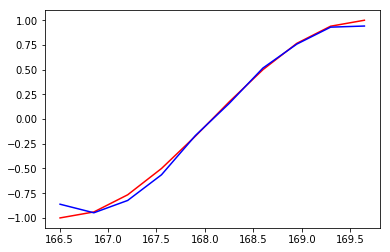

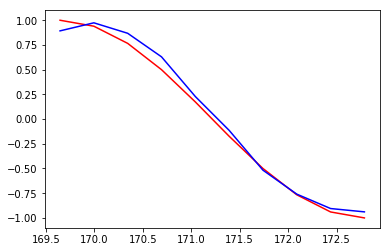

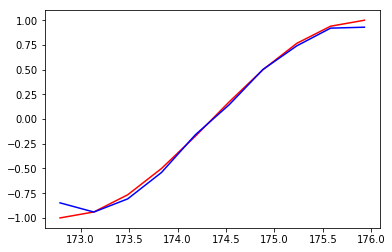

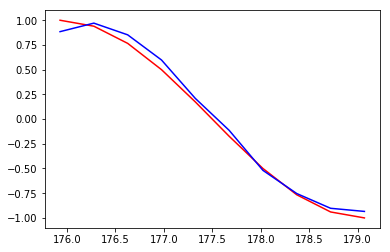

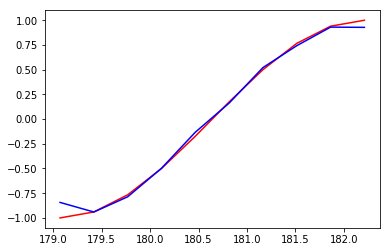

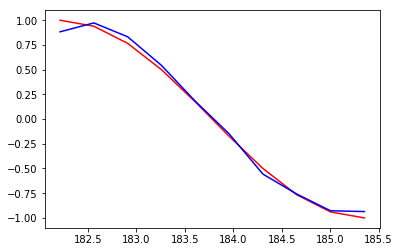

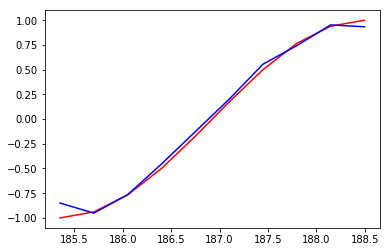

In [12]:
# torch.manual_seed(1)    # reproducible
r2 = []
for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32) # float32 for converting torch FloatTensor
    x_np = np.sin(steps)  
    y_np = np.cos(steps)

    """
    https://pytorch.org/blog/pytorch-0_4_0-migration-guide/
    Variable wrapper is no longer needed!
    """
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    # shape (batch, time_step, input_size)
#     y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])   # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    
    prediction, h_state = rnn(x, h_state)   # rnn output

    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    """
    The following line solves:
    RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
    https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
    """
    loss.backward(retain_graph=True)        # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
#     plt.plot(steps, prediction.data[0,...].numpy().flatten(), 'b-') #used when batch_size>=2
    plt.draw(); plt.pause(0.05)
    r2.append(prediction.data.numpy().flatten())